In [1]:
#!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 28.0 MB/s 
     |████████████████████████████████| 6.6 MB 54.0 MB/s 
     |████████████████████████████████| 120 kB 60.3 MB/s 


In [2]:
#!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 32.7 MB/s 


In [3]:
#!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 34.4 MB/s 
     |████████████████████████████████| 212 kB 57.1 MB/s 
     |████████████████████████████████| 115 kB 64.6 MB/s 
     |████████████████████████████████| 127 kB 65.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
import datasets

In [5]:
from datasets import list_datasets
from datasets import load_dataset

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

In [7]:
from datasets import Features, ClassLabel, Value
class_names = ["Hope_speech", "Non_hope_speech", "not-Tamil"]
hope_edi_features = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})
hope_edi = load_dataset('csv', data_files={'train':'/content/preprocessed_hope_edi_tamil_train.csv', 'validation':'/content/preprocessed_hope_edi_tamil_valid.csv'}, features=hope_edi_features)

Generating train split:   0%|          | 0/16160 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2018 [00:00<?, ? examples/s]

Dataset hope_edi downloaded and prepared to /root/.cache/huggingface/datasets/hope_edi/tamil/1.0.0/fff5cf6e767fe3d1de7c5df863565bdce10bfe79dfb0b2ce42d320c3864497e3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
hope_edi

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16160
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2018
    })
})

In [9]:
#from google.colab import output
#output.disable_custom_widget_manager()

In [10]:
train_ds = hope_edi["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16160
})

In [11]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=3, names=['Hope_speech', 'Non_hope_speech', 'not-Tamil'], id=None)}


In [12]:
import pandas as pd

hope_edi.set_format(type="pandas")
df = hope_edi["train"][:]
df.head()

,text,label
0,Realme india product,2
1,I also don't have tiktok hello and allnBut I'm...,0
2,Thalaivare..neengale inum one plus mobile vach...,1
3,Annee varanda thondai.. corona virus affect pa...,0
4,5views but 18likes,1


In [13]:
def label_int2str(row):
    return hope_edi["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,Realme india product,2,not-Tamil
1,I also don't have tiktok hello and allnBut I'm...,0,Hope_speech
2,Thalaivare..neengale inum one plus mobile vach...,1,Non_hope_speech
3,Annee varanda thondai.. corona virus affect pa...,0,Hope_speech
4,5views but 18likes,1,Non_hope_speech


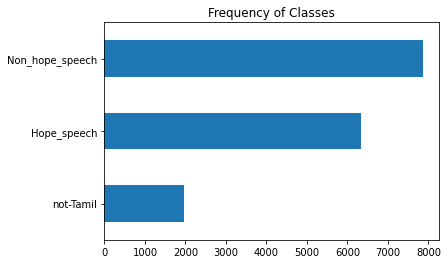

In [14]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [16]:
hope_edi.reset_format()

In [17]:
from datasets import Features, ClassLabel, Value
class_names = ["Hope_speech", "Non_hope_speech", "not-Tamil"]
hope_edi_features = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})
hope_edi_test = load_dataset('csv', data_files={'test':'/content/preprocessed_hope_edi_tamil_test.csv'}, features=hope_edi_features)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-bcd4bdd75bf51899/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
import numpy as np
import torch
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [19]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
batch_size = 32
learning_rate = 1e-5
weight_decay = 0.01
max_len = 256
epochs = 4

In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    p = precision_score(labels, preds, average="weighted")
    r = recall_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, 'precision': p, 'recall': r}

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    cm1 = confusion_matrix(y_true, y_preds)
    fig = plt.figure(figsize=(20,10))
    fig.subplots(2, 1, squeeze=False)
    ax1 = plt.subplot(2,1,1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax1, colorbar=False)
    plt.title("Normalized confusion matrix")
    ax2 = plt.subplot(2,1,2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
    disp.plot(cmap="Greens", ax=ax2, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()

In [23]:
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers import Trainer

train_labels = df['label'].values
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=class_wts)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [24]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [25]:
tokenizer.model_max_length=max_len

In [42]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [43]:
tokenizer.vocab_size

119547

In [44]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [45]:
print(tokenize(hope_edi["train"][:2]))

{'input_ids': [[101, 12384, 10627, 55210, 21535, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 146, 10379, 16938, 112, 188, 10529, 24627, 20715, 61694, 10133, 10111, 10435, 10115, 11274, 11159, 146, 112, 181, 13382, 192, 10280, 32013, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [46]:
#hide_input
import pandas as pd
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [47]:
hope_edi_encoded = hope_edi.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [48]:
print(hope_edi_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [49]:
hope_edi_test_encoded = hope_edi_test.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [50]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [51]:
from transformers import Trainer, TrainingArguments

logging_steps = len(hope_edi_encoded["train"]) // batch_size
save_steps = logging_steps*epochs
model_name = f"{model_ckpt}-finetuned-hope"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=weight_decay,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=save_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [52]:
from transformers import Trainer

trainer = CustomTrainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=hope_edi_encoded["train"],
                  eval_dataset=hope_edi_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.808600,0.759443,0.600099,0.567714,0.608054,0.600099
2,0.735300,0.736484,0.611992,0.594563,0.609282,0.611992
3,0.695900,0.748197,0.600595,0.600109,0.602543,0.600595
4,0.668200,0.742593,0.613479,0.604541,0.609369,0.613479


TrainOutput(global_step=2020, training_loss=0.7270037358350093, metrics={'train_runtime': 824.2645, 'train_samples_per_second': 78.421, 'train_steps_per_second': 2.451, 'total_flos': 4281422676295680.0, 'train_loss': 0.7270037358350093, 'epoch': 4.0})

In [53]:
preds_output = trainer.predict(hope_edi_encoded["validation"])
preds_output.metrics

{'test_loss': 0.7425928115844727,
 'test_accuracy': 0.6134786917740337,
 'test_f1': 0.604541029529418,
 'test_precision': 0.6093692069497576,
 'test_recall': 0.6134786917740337,
 'test_runtime': 8.371,
 'test_samples_per_second': 241.072,
 'test_steps_per_second': 7.645}

In [54]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(hope_edi_encoded["validation"]["label"])
labels = hope_edi_encoded["train"].features["label"].names

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_preds))

              precision    recall  f1-score   support

           0       0.58      0.43      0.49       757
           1       0.63      0.73      0.68       998
           2       0.59      0.70      0.64       263

    accuracy                           0.61      2018
   macro avg       0.60      0.62      0.60      2018
weighted avg       0.61      0.61      0.60      2018



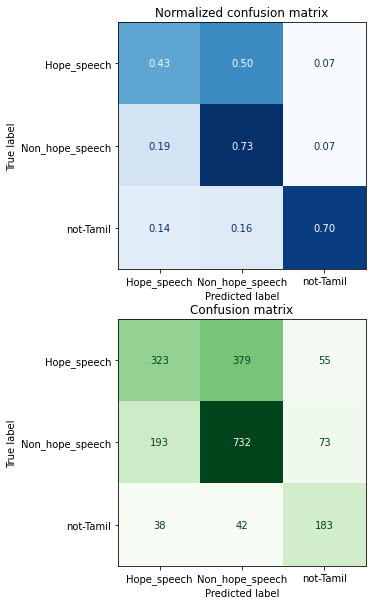

In [56]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [57]:
preds_train = trainer.predict(hope_edi_encoded["train"])
y_pred_train = np.argmax(preds_train.predictions, axis=1)
y_train = np.array(hope_edi_encoded["train"]["label"])
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.72      0.49      0.59      6327
           1       0.69      0.80      0.74      7872
           2       0.66      0.87      0.75      1961

    accuracy                           0.69     16160
   macro avg       0.69      0.72      0.69     16160
weighted avg       0.70      0.69      0.68     16160



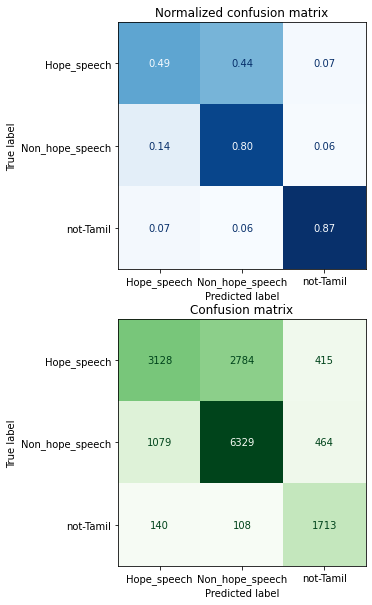

In [58]:
plot_confusion_matrix(y_pred_train, y_train, labels)

In [ ]:
#!zip -r /content/distilm.zip /content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-8080

  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-8080/ (stored 0%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-8080/optimizer.pt (deflated 65%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-8080/training_args.bin (deflated 48%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-8080/config.json (deflated 49%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-8080/tokenizer.json (deflated 67%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-8080/scheduler.pt (deflated 50%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-8080/vocab.txt (deflated 45%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-8080/trainer_state.json (deflated 76%)
  adding: content/distilbert-base-multilingual-cased-finetuned-hope/checkpoint-8080/pytorch_model.bin (deflate

In [59]:
preds_test = trainer.predict(hope_edi_test_encoded["test"])
y_pred_test = np.argmax(preds_test.predictions, axis=1)
y_test = np.array(hope_edi_test_encoded["test"]["label"])
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.62      0.40      0.48       815
           1       0.60      0.74      0.66       946
           2       0.56      0.73      0.63       259

    accuracy                           0.60      2020
   macro avg       0.59      0.62      0.59      2020
weighted avg       0.60      0.60      0.59      2020



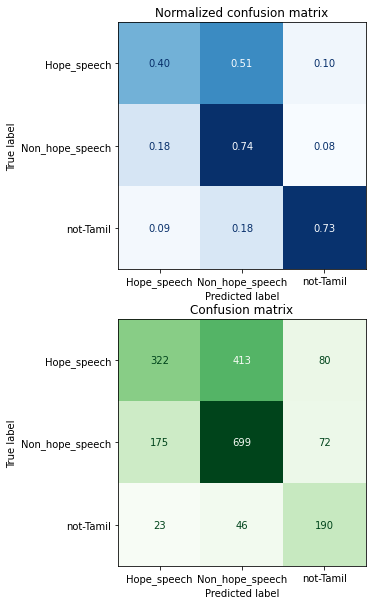

In [60]:
plot_confusion_matrix(y_pred_test, y_test, labels)

In [61]:
from transformers import AutoTokenizer

indicbert_model_ckpt = "ai4bharat/indic-bert"
indic_tokenizer = AutoTokenizer.from_pretrained(indicbert_model_ckpt)

In [62]:
indic_tokenizer.model_max_length=max_len

In [63]:
indic_tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [64]:
indic_tokenizer.vocab_size

200000

In [65]:
def indic_tokenize(batch):
    return indic_tokenizer(batch["text"], padding=True, truncation=True)

In [66]:
hope_edi_indic_encoded = hope_edi.map(indic_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [67]:
hope_edi_test_indic_encoded = hope_edi_test.map(indic_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [68]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
indic_model = (AutoModelForSequenceClassification
         .from_pretrained(indicbert_model_ckpt, num_labels=num_labels)
         .to(device))

In [69]:
from transformers import Trainer, TrainingArguments

logging_steps = len(hope_edi_indic_encoded["train"]) // batch_size
save_steps = logging_steps*epochs
indic_model_name = f"{indicbert_model_ckpt}-finetuned-hope"
indic_training_args = TrainingArguments(output_dir=indic_model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=weight_decay,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=save_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [70]:
from transformers import Trainer

indic_trainer = CustomTrainer(model=indic_model, args=indic_training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=hope_edi_indic_encoded["train"],
                  eval_dataset=hope_edi_indic_encoded["validation"],
                  tokenizer=indic_tokenizer)
indic_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.865200,0.820327,0.502973,0.394264,0.377003,0.502973
2,0.809700,0.804516,0.562438,0.553106,0.552300,0.562438
3,0.772700,0.802153,0.558969,0.556245,0.567939,0.558969
4,0.742000,0.799657,0.582755,0.572957,0.577032,0.582755


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=2020, training_loss=0.797382135674505, metrics={'train_runtime': 1509.3418, 'train_samples_per_second': 42.827, 'train_steps_per_second': 1.338, 'total_flos': 772463000616960.0, 'train_loss': 0.797382135674505, 'epoch': 4.0})

In [71]:
preds_indic_output = indic_trainer.predict(hope_edi_indic_encoded["validation"])
preds_indic_output.metrics

{'test_loss': 0.79965740442276,
 'test_accuracy': 0.5827552031714569,
 'test_f1': 0.5729567479987672,
 'test_precision': 0.577031898657457,
 'test_recall': 0.5827552031714569,
 'test_runtime': 16.0015,
 'test_samples_per_second': 126.114,
 'test_steps_per_second': 4.0}

In [72]:
import numpy as np
indic_y_preds = np.argmax(preds_indic_output.predictions, axis=1)
indic_y_valid = np.array(hope_edi_indic_encoded["validation"]["label"])
indic_labels = hope_edi_indic_encoded["validation"].features["label"].names

In [73]:
from sklearn.metrics import classification_report
print(classification_report(indic_y_valid, indic_y_preds))

              precision    recall  f1-score   support

           0       0.52      0.39      0.45       757
           1       0.63      0.66      0.64       998
           2       0.56      0.84      0.68       263

    accuracy                           0.58      2018
   macro avg       0.57      0.63      0.59      2018
weighted avg       0.58      0.58      0.57      2018



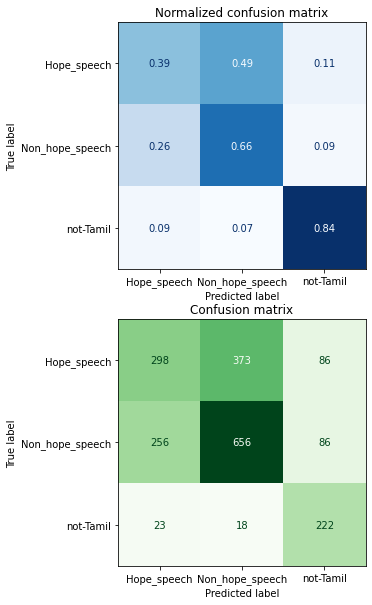

In [74]:
plot_confusion_matrix(indic_y_preds, indic_y_valid, indic_labels)

In [75]:
preds_indic_train = indic_trainer.predict(hope_edi_indic_encoded["train"])
indic_y_pred_train = np.argmax(preds_indic_train.predictions, axis=1)
indic_y_train = np.array(hope_edi_indic_encoded["train"]["label"])
print(classification_report(indic_y_train, indic_y_pred_train))

              precision    recall  f1-score   support

           0       0.65      0.50      0.57      6327
           1       0.68      0.73      0.71      7872
           2       0.59      0.88      0.70      1961

    accuracy                           0.66     16160
   macro avg       0.64      0.70      0.66     16160
weighted avg       0.66      0.66      0.65     16160



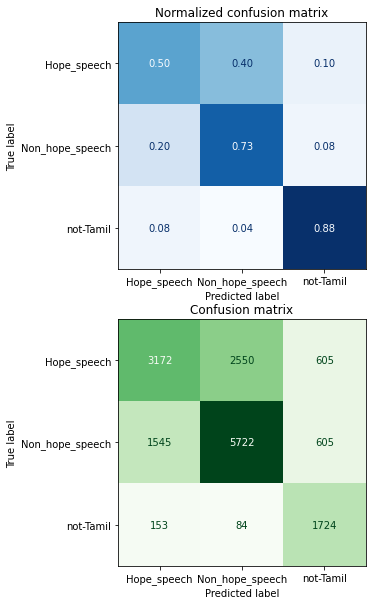

In [76]:
plot_confusion_matrix(indic_y_pred_train, indic_y_train, indic_labels)

In [77]:
preds_indic_test = indic_trainer.predict(hope_edi_test_indic_encoded["test"])
indic_y_pred_test = np.argmax(preds_indic_test.predictions, axis=1)
indic_y_test = np.array(hope_edi_test_indic_encoded["test"]["label"])
print(classification_report(indic_y_test, indic_y_pred_test))

              precision    recall  f1-score   support

           0       0.53      0.40      0.46       815
           1       0.59      0.65      0.62       946
           2       0.54      0.78      0.64       259

    accuracy                           0.56      2020
   macro avg       0.55      0.61      0.57      2020
weighted avg       0.56      0.56      0.56      2020



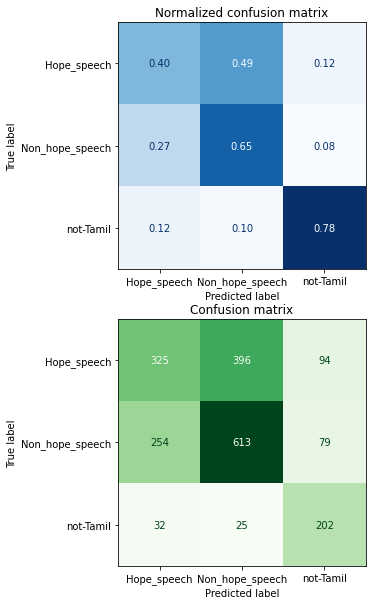

In [78]:
plot_confusion_matrix(indic_y_pred_test, indic_y_test, indic_labels)

In [ ]:
#!zip -r /content/indic.zip /content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080

  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080/ (stored 0%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080/optimizer.pt (deflated 76%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080/training_args.bin (deflated 48%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080/config.json (deflated 54%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080/tokenizer.json (deflated 77%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080/scheduler.pt (deflated 50%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080/trainer_state.json (deflated 76%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080/pytorch_model.bin (deflated 7%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080/special_tokens_map.json (deflated 49%)
  adding: content/ai4bharat/indic-bert-finetuned-hope/checkpoint-8080/spiece.model (deflated 60%)
  adding

In [24]:
from transformers import AutoTokenizer

muril_model_ckpt = "google/muril-base-cased"
muril_tokenizer = AutoTokenizer.from_pretrained(muril_model_ckpt)

In [25]:
muril_tokenizer.model_max_length=max_len

In [26]:
muril_tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [27]:
muril_tokenizer.vocab_size

197285

In [28]:
def muril_tokenize(batch):
    return muril_tokenizer(batch["text"], padding=True, truncation=True)

In [29]:
hope_edi_muril_encoded = hope_edi.map(muril_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [30]:
print(hope_edi_muril_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [31]:
hope_edi_test_muril_encoded = hope_edi_test.map(muril_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
muril_model = (AutoModelForSequenceClassification
         .from_pretrained(muril_model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not in

In [34]:
from transformers import Trainer, TrainingArguments

logging_steps = len(hope_edi_muril_encoded["train"]) // batch_size
save_steps = logging_steps*epochs
muril_model_name = f"{muril_model_ckpt}-finetuned-hope"
muril_training_args = TrainingArguments(output_dir=muril_model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=weight_decay,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=save_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [35]:
from transformers import Trainer

muril_trainer = CustomTrainer(model=muril_model, args=muril_training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=hope_edi_muril_encoded["train"],
                  eval_dataset=hope_edi_muril_encoded["validation"],
                  tokenizer=muril_tokenizer)
muril_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.967600,0.870415,0.553023,0.434169,0.469790,0.553023
2,0.831600,0.812225,0.556987,0.443997,0.463632,0.556987
3,0.797000,0.797510,0.557483,0.461432,0.486562,0.557483
4,0.781800,0.799575,0.560456,0.466195,0.486556,0.560456


TrainOutput(global_step=2020, training_loss=0.844498330295676, metrics={'train_runtime': 2809.658, 'train_samples_per_second': 23.006, 'train_steps_per_second': 0.719, 'total_flos': 8503825660968960.0, 'train_loss': 0.844498330295676, 'epoch': 4.0})

In [36]:
preds_muril_output = muril_trainer.predict(hope_edi_muril_encoded["validation"])
preds_muril_output.metrics

{'test_loss': 0.7995749711990356,
 'test_accuracy': 0.5604558969276512,
 'test_f1': 0.46619459964203075,
 'test_precision': 0.4865564863209149,
 'test_recall': 0.5604558969276512,
 'test_runtime': 29.9704,
 'test_samples_per_second': 67.333,
 'test_steps_per_second': 2.135}

In [37]:
import numpy as np
muril_y_preds = np.argmax(preds_muril_output.predictions, axis=1)
muril_y_valid = np.array(hope_edi_muril_encoded["validation"]["label"])
muril_labels = hope_edi_muril_encoded["validation"].features["label"].names

In [38]:
from sklearn.metrics import classification_report
print(classification_report(muril_y_valid, muril_y_preds))

              precision    recall  f1-score   support

           0       0.34      0.05      0.09       757
           1       0.57      0.89      0.69       998
           2       0.59      0.78      0.67       263

    accuracy                           0.56      2018
   macro avg       0.50      0.57      0.49      2018
weighted avg       0.49      0.56      0.47      2018



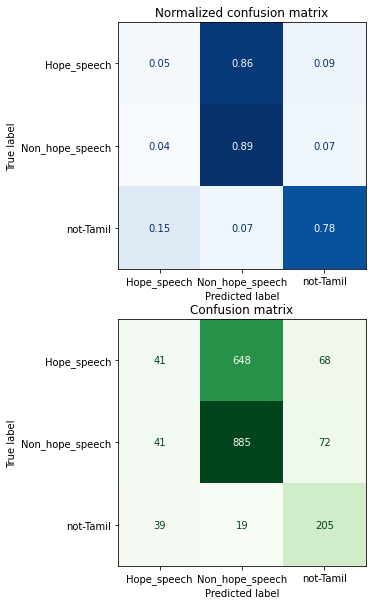

In [39]:
plot_confusion_matrix(muril_y_preds, muril_y_valid, muril_labels)

In [40]:
preds_muril_train = muril_trainer.predict(hope_edi_muril_encoded["train"])
muril_y_pred_train = np.argmax(preds_muril_train.predictions, axis=1)
muril_y_train = np.array(hope_edi_muril_encoded["train"]["label"])
print(classification_report(muril_y_train, muril_y_pred_train))

              precision    recall  f1-score   support

           0       0.41      0.05      0.09      6327
           1       0.56      0.90      0.69      7872
           2       0.64      0.87      0.74      1961

    accuracy                           0.57     16160
   macro avg       0.54      0.61      0.51     16160
weighted avg       0.51      0.57      0.46     16160



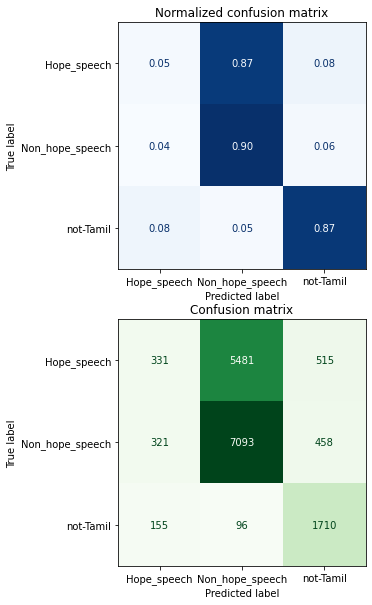

In [41]:
plot_confusion_matrix(muril_y_pred_train, muril_y_train, muril_labels)

In [42]:
preds_muril_test = muril_trainer.predict(hope_edi_test_muril_encoded["test"])
muril_y_pred_test = np.argmax(preds_muril_test.predictions, axis=1)
muril_y_test = np.array(hope_edi_test_muril_encoded["test"]["label"])
print(classification_report(muril_y_test, muril_y_pred_test))

              precision    recall  f1-score   support

           0       0.42      0.05      0.09       815
           1       0.54      0.89      0.68       946
           2       0.54      0.76      0.63       259

    accuracy                           0.54      2020
   macro avg       0.50      0.57      0.47      2020
weighted avg       0.49      0.54      0.43      2020



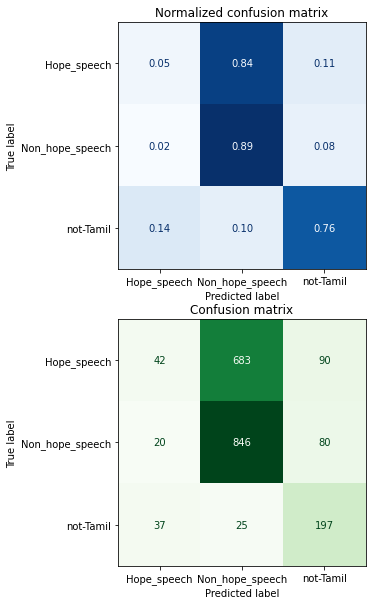

In [43]:
plot_confusion_matrix(muril_y_pred_test, muril_y_test, muril_labels)

In [ ]:
#!zip -r /content/muril.zip /content/google/muril-base-cased-finetuned-hope/checkpoint-8080

  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-8080/ (stored 0%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-8080/optimizer.pt (deflated 62%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-8080/training_args.bin (deflated 48%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-8080/config.json (deflated 52%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-8080/tokenizer.json (deflated 70%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-8080/scheduler.pt (deflated 50%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-8080/vocab.txt (deflated 61%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-8080/trainer_state.json (deflated 77%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-8080/pytorch_model.bin (deflated 7%)
  adding: content/google/muril-base-cased-finetuned-hope/checkpoint-8080/special_tokens_map.j

In [26]:
from transformers import AutoTokenizer

xlmr_model_ckpt = "xlm-roberta-base"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_ckpt)

In [27]:
xlmr_tokenizer.model_max_length=max_len

In [28]:
def xlmr_tokenize(batch):
    return xlmr_tokenizer(batch["text"], padding=True, truncation=True)

In [29]:
hope_edi_xlmr_encoded = hope_edi.map(xlmr_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [30]:
hope_edi_test_xlmr_encoded = hope_edi_test.map(xlmr_tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [31]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
xlmr_model = (AutoModelForSequenceClassification
         .from_pretrained(xlmr_model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [32]:
from transformers import Trainer, TrainingArguments

epochs = 4
logging_steps = len(hope_edi_xlmr_encoded["train"]) // batch_size
xlmr_model_name = f"{xlmr_model_ckpt}-finetuned-hope"
xlmr_training_args = TrainingArguments(output_dir=xlmr_model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=weight_decay,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=5000,
                                  push_to_hub=False, 
                                  log_level="error")

In [33]:
from transformers import Trainer

xlmr_trainer = CustomTrainer(model=xlmr_model, args=xlmr_training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=hope_edi_xlmr_encoded["train"],
                  eval_dataset=hope_edi_xlmr_encoded["validation"],
                  tokenizer=xlmr_tokenizer)
xlmr_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.845000,0.777354,0.583251,0.535538,0.574796,0.583251
2,0.767800,0.747863,0.605055,0.596725,0.599301,0.605055
3,0.737700,0.757958,0.586224,0.587514,0.598010,0.586224
4,0.718500,0.726007,0.624381,0.614587,0.621704,0.624381


TrainOutput(global_step=2020, training_loss=0.7672458157681002, metrics={'train_runtime': 1647.9761, 'train_samples_per_second': 39.224, 'train_steps_per_second': 1.226, 'total_flos': 8503825660968960.0, 'train_loss': 0.7672458157681002, 'epoch': 4.0})

In [34]:
preds_xlmr_output = xlmr_trainer.predict(hope_edi_xlmr_encoded["validation"])
preds_xlmr_output.metrics

{'test_loss': 0.7260065674781799,
 'test_accuracy': 0.624380574826561,
 'test_f1': 0.6145872174225481,
 'test_precision': 0.6217036896097762,
 'test_recall': 0.624380574826561,
 'test_runtime': 15.8746,
 'test_samples_per_second': 127.122,
 'test_steps_per_second': 4.032}

In [35]:
import numpy as np
xlmr_y_preds = np.argmax(preds_xlmr_output.predictions, axis=1)
xlmr_y_valid = np.array(hope_edi_xlmr_encoded["validation"]["label"])
xlmr_labels = hope_edi_xlmr_encoded["validation"].features["label"].names

In [36]:
from sklearn.metrics import classification_report
print(classification_report(xlmr_y_valid, xlmr_y_preds))

              precision    recall  f1-score   support

           0       0.60      0.43      0.50       757
           1       0.65      0.74      0.69       998
           2       0.57      0.76      0.65       263

    accuracy                           0.62      2018
   macro avg       0.61      0.64      0.61      2018
weighted avg       0.62      0.62      0.61      2018



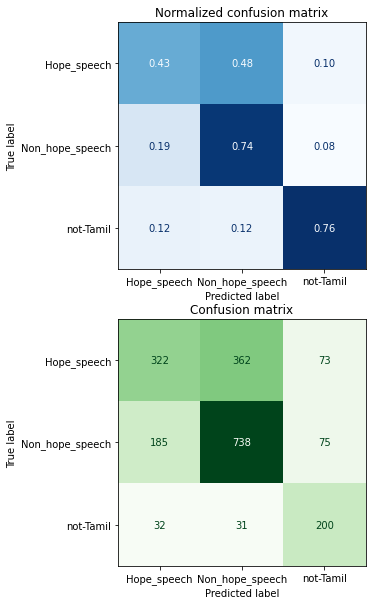

In [37]:
plot_confusion_matrix(xlmr_y_preds, xlmr_y_valid, xlmr_labels)

In [38]:
preds_xlmr_train = xlmr_trainer.predict(hope_edi_xlmr_encoded["train"])
xlmr_y_pred_train = np.argmax(preds_xlmr_train.predictions, axis=1)
xlmr_y_train = np.array(hope_edi_xlmr_encoded["train"]["label"])
print(classification_report(xlmr_y_train, xlmr_y_pred_train))

              precision    recall  f1-score   support

           0       0.66      0.47      0.55      6327
           1       0.66      0.76      0.71      7872
           2       0.61      0.83      0.71      1961

    accuracy                           0.65     16160
   macro avg       0.65      0.69      0.65     16160
weighted avg       0.66      0.65      0.65     16160



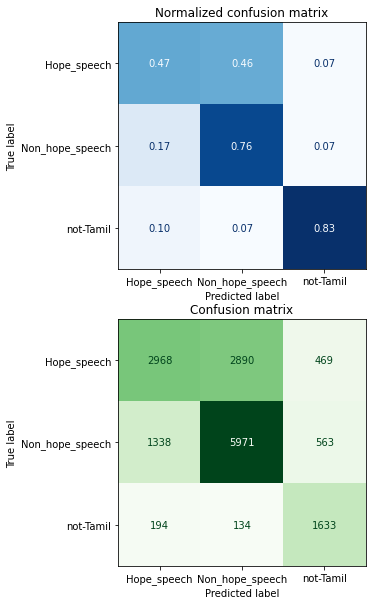

In [39]:
plot_confusion_matrix(xlmr_y_pred_train, xlmr_y_train, xlmr_labels)

In [40]:
preds_xlmr_test = xlmr_trainer.predict(hope_edi_test_xlmr_encoded["test"])
xlmr_y_pred_test = np.argmax(preds_xlmr_test.predictions, axis=1)
xlmr_y_test = np.array(hope_edi_test_xlmr_encoded["test"]["label"])
print(classification_report(xlmr_y_test, xlmr_y_pred_test))

              precision    recall  f1-score   support

           0       0.60      0.41      0.49       815
           1       0.62      0.72      0.66       946
           2       0.54      0.73      0.62       259

    accuracy                           0.60      2020
   macro avg       0.59      0.62      0.59      2020
weighted avg       0.60      0.60      0.59      2020



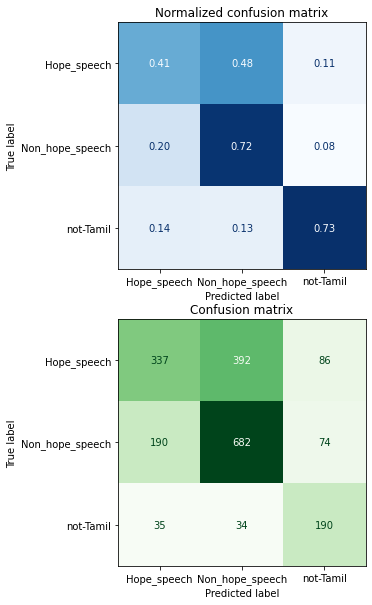

In [41]:
plot_confusion_matrix(xlmr_y_pred_test, xlmr_y_test, xlmr_labels)